# Tarea1: Clasificador de género

* José Terrazas
* Benjamin Vasquez

## Primero procedemos a cargar las librerías que se utilizarán:

In [1]:
from PIL import Image
from scipy import ndimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from os import listdir
import cv2
import sys
import math

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix


from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb


#/home/jose/Desktop/Web Intelligence t1/Tarea1/data/Gender/Female/
#image.resize((200,200)).show()

## Creamos Data frame con las posiciones de los ojos:

In [2]:
ruta_female = "/home/jose/Desktop/Web Intelligence t1/Tarea1/data/Gender/Female/"
ruta_male = "/home/jose/Desktop/Web Intelligence t1/Tarea1/data/Gender/Male/"

#vectores con las imagenes
female=[]
for archivo in listdir(ruta_female):
    if archivo[-3:]=="txt":
        female.append(archivo)

male=[]
for archivo in listdir(ruta_male):
    if archivo[-3:]=="txt":
        male.append(archivo)

#variables del data frame
xl=[] 
yl=[] 
xr=[] 
yr=[] 
gender=[]
foto=[] 

for foto_i in female:
    for linea in open(ruta_female+foto_i, 'r'):
        l=linea.split(" ")
        xl.append(int(l[0]))
        yl.append(int(l[1]))
        xr.append(int(l[2]))
        yr.append(int(l[3]))
        gender.append('female')
        foto.append(foto_i[:-4])
        
for foto_i in male:
    for linea in open(ruta_male+foto_i, 'r'):
        l=linea.split(" ")
        xl.append(int(l[0]))
        yl.append(int(l[1]))
        xr.append(int(l[2]))
        yr.append(int(l[3]))
        gender.append('male')
        foto.append(foto_i[:-4])
        
df=pd.DataFrame({'xl':xl,'yl':yl,'xr':xr,'yr':yr,'gender':gender,'foto':foto})

## Funciones a utilizar

### 1. Función para hacer Crop Face ( extraída de https://www.bytefish.de/blog/aligning_face_images/ )

In [3]:
#funciones extraídas de https://www.bytefish.de/blog/aligning_face_images/

def Distance(p1,p2):
  dx = p2[0] - p1[0]
  dy = p2[1] - p1[1]
  return math.sqrt(dx*dx+dy*dy)

def ScaleRotateTranslate(image, angle, center = None, new_center = None, scale = None, resample=Image.BICUBIC):
  if (scale is None) and (center is None):
    return image.rotate(angle=angle, resample=resample)
  nx,ny = x,y = center
  sx=sy=1.0
  if new_center:
    (nx,ny) = new_center
  if scale:
    (sx,sy) = (scale, scale)
  cosine = math.cos(angle)
  sine = math.sin(angle)
  a = cosine/sx
  b = sine/sx
  c = x-nx*a-ny*b
  d = -sine/sy
  e = cosine/sy
  f = y-nx*d-ny*e
  return image.transform(image.size, Image.AFFINE, (a,b,c,d,e,f), resample=resample)

def CropFace(image, eye_left=(0,0), eye_right=(0,0), offset_pct=(0.2,0.2), dest_sz = (70,70)):
  # calculate offsets in original image
  offset_h = math.floor(float(offset_pct[0])*dest_sz[0])
  offset_v= math.floor(float(offset_pct[1])*dest_sz[1])
  # get the direction
  eye_direction = (eye_right[0] - eye_left[0], eye_right[1] - eye_left[1])
  # calc rotation angle in radians
  rotation = -math.atan2(float(eye_direction[1]),float(eye_direction[0]))
  # distance between them
  dist = Distance(eye_left, eye_right)
  # calculate the reference eye-width
  reference = dest_sz[0] - 2.0*offset_h
  # scale factor
  scale = float(dist)/float(reference)
  # rotate original around the left eye
  image = ScaleRotateTranslate(image, center=eye_left, angle=rotation)
  # crop the rotated image
  crop_xy = (eye_left[0] - scale*offset_h, eye_left[1] - scale*offset_v)
  crop_size = (dest_sz[0]*scale, dest_sz[1]*scale)
  image = image.crop((int(crop_xy[0]), int(crop_xy[1]), int(crop_xy[0]+crop_size[0]), int(crop_xy[1]+crop_size[1])))
  # resize it
  image = image.resize(dest_sz, Image.ANTIALIAS)
  return image

### 2. Función que calcula Local Binary Pattern de la imagen

In [4]:
def lbp(img):
    w,h=img.size
    a=np.ones((w-1,h-1))
    m=np.array(img)
    for y in range(1,h-1):
        for x in range(1,w-1):
            vec=[m[y-1][x+1],m[y][x+1],m[y+1][x+1],m[y+1][x],m[y+1][x-1],m[y][x-1],m[y-1][x-1],m[y-1][x]]
            c=0
            for v in range(0,len(vec)):
                if(m[y][x]<=vec[v]):
                    c=c+2**v
            a[y-1][x-1]=c
    return a
def cambios(vec):
    c=0
    for i in range(0,len(vec)-1):
        if vec[i]!=vec[i+1]:
            c=c+1
    return c

def lbp_unif(img):
    w,h= img.size #tamaño imagen
    lbp=np.ones((w-1,h-1)) # Matri de 1s
    m=np.array(img) #imagen to array
    
    # Recorrer la matriz
    for y in range(1,h-1):
        for x in range(1,w-1):
            #Vector con pixeles vecinos
            vec=[m[y-1][x+1],m[y][x+1],m[y+1][x+1],m[y+1][x],m[y+1][x-1],m[y][x-1],m[y-1][x-1],m[y-1][x]]
            vec2=[m[y-1][x+1],m[y][x+1],m[y+1][x+1],m[y+1][x],m[y+1][x-1],m[y][x-1],m[y-1][x-1],m[y-1][x]]
            c=0 #valor del nuevo pixel
            for v in range(0,len(vec)):
                if(m[y][x]<=vec[v]):
                    vec2[v]=1
                    c=c+2**v
                else:
                    vec2[v]=0
            if(cambios(vec2)<=2):
                lbp[y-1][x-1]=c
            else:
                lbp[y-1][x-1]=256
    return lbp

In [5]:
def hist_lbp(image):
    img=lbp_unif(image).ravel()
    w,h=image.size
    key=sorted(list(collections.Counter(img).keys()))
    val=collections.Counter(img)
    hist=[]
    for i in range(0,len(key)):
        hist.append(int(val[key[i]]))
    hist=np.array(hist)/((w-1)*(h-1))
    key=np.array(key)
    return pd.DataFrame({'key':key,'val':hist})

#### Ejemplos de función LBP

##### Female

In [ ]:
ruta="/home/jose/Desktop/Web Intelligence t1/Data/"

#Ejemplo female
df1=df[df['foto']=='female0050']

image1=Image.open(ruta+"female0050.jpg")

#img1 la cara cortada y rotada
img1=CropFace(image1,(df1['xl'],df1['yl']),(df1['xr'],df1['yr']),offset_pct=(0.3,0.35),dest_sz=(200,200))

lbp_img1=lbp(img1)
lbp_img1=Image.fromarray(lbp_img1)

lbp_unif_img1=lbp_unif(img1)
lbp_unif_img1=Image.fromarray(lbp_unif_img1)

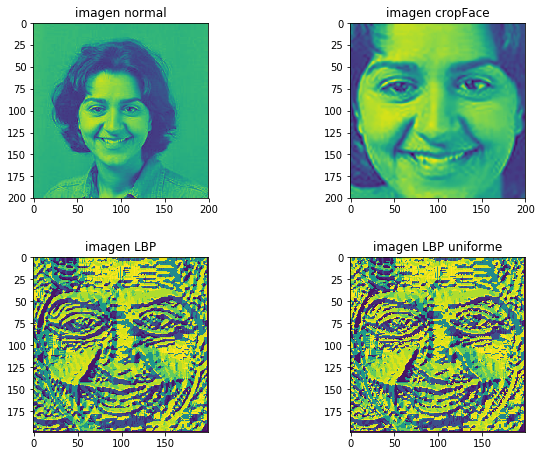

In [47]:
im1=np.array(image1)
im2=np.array(img1)
im3=np.array(lbp_img1)
im4=np.array(lbp_unif_img1)

plt.figure(2)

plt.subplot(221)
plt.imshow(im1)
plt.title("imagen normal")

plt.subplot(222)
plt.imshow(im2)
plt.title("imagen cropFace")

plt.subplot(223)
plt.imshow(im3)
plt.title("imagen LBP")

plt.subplot(224)
plt.imshow(im4)
plt.title("imagen LBP uniforme")

plt.subplots_adjust(top=1.5, bottom=0.08, left=0.10, right=1.5, hspace=0.34,
                    wspace=0.1) 

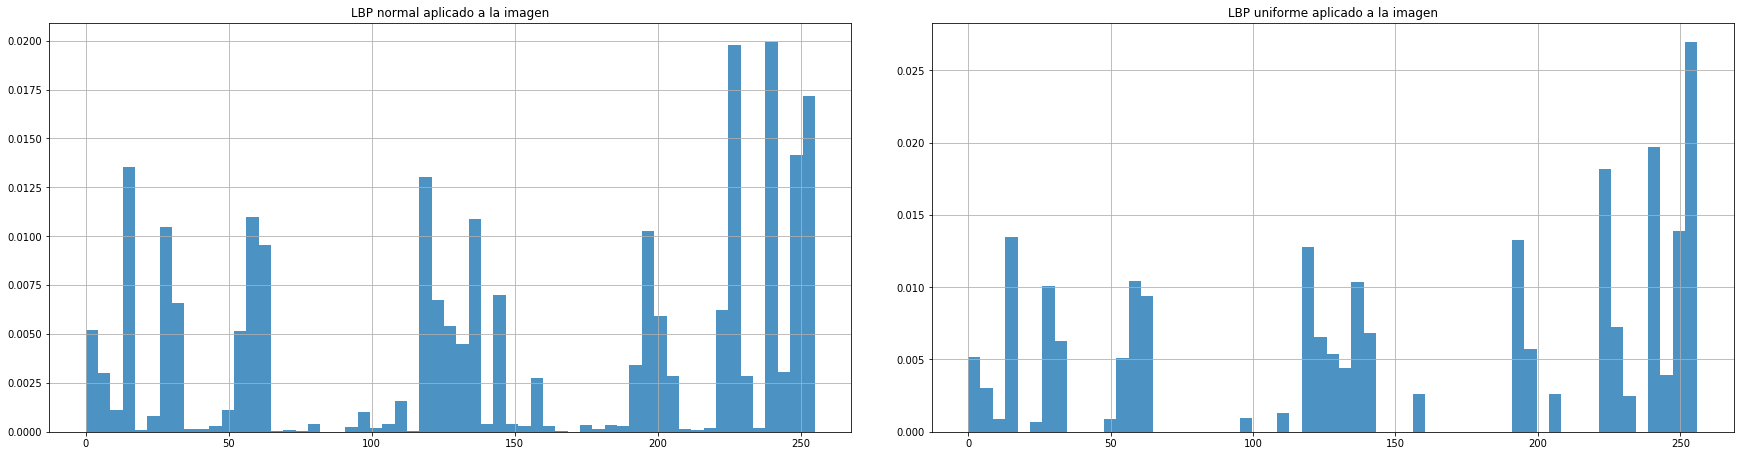

In [14]:
plt.figure(2)

hist_img1=list(lbp_img1.getdata())
plt.subplot(121)
plt.hist(hist_img1,59,alpha=0.8, normed=True)
plt.title("LBP normal aplicado a la imagen")
#plt.xlim((0,255))
plt.grid(True)


hist_unif_img1=list(lbp_unif_img1.getdata())

plt.subplot(122)
plt.hist(hist_unif_img1,59,alpha=0.8, normed=True)
plt.title("LBP uniforme aplicado a la imagen")
#plt.xlim((0,58))
plt.grid(True)

plt.subplots_adjust(top=1.5, bottom=0.08, left=0.10, right=4, hspace=0.34,
                    wspace=0.1) 

##### Male

In [ ]:
ruta="/home/jose/Desktop/Web Intelligence t1/Data/"

#Ejemplo male
df2=df[df['foto']=='male0100']

image2=Image.open(ruta+"male0100.jpg")

#img2 la cara cortada y rotada
img2=CropFace(image2,(df2['xl'],df2['yl']),(df2['xr'],df2['yr']),offset_pct=(0.3,0.35),dest_sz=(200,200))

lbp_img2=lbp(img2)
lbp_img2=Image.fromarray(lbp_img2)

lbp_unif_img2=lbp_unif(img2)
lbp_unif_img2=Image.fromarray(lbp_unif_img2)

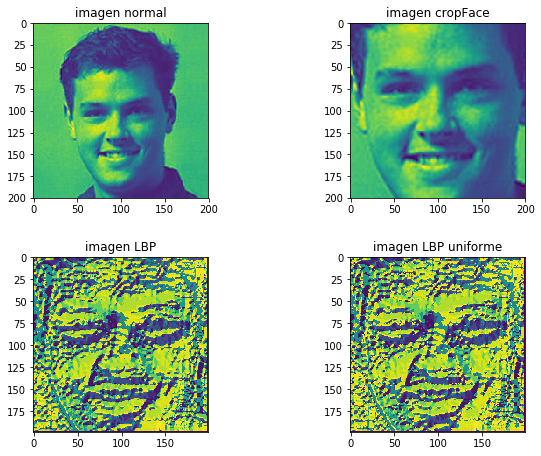

In [48]:
im1=np.array(image2)
im2=np.array(img2)
im3=np.array(lbp_img2)
im4=np.array(lbp_unif_img2)

plt.figure(2)

plt.subplot(221)
plt.imshow(im1)
plt.title("imagen normal")

plt.subplot(222)
plt.imshow(im2)
plt.title("imagen cropFace")

plt.subplot(223)
plt.imshow(im3)
plt.title("imagen LBP")

plt.subplot(224)
plt.imshow(im4)
plt.title("imagen LBP uniforme")

plt.subplots_adjust(top=1.5, bottom=0.08, left=0.10, right=1.5, hspace=0.34,
                    wspace=0.1) 

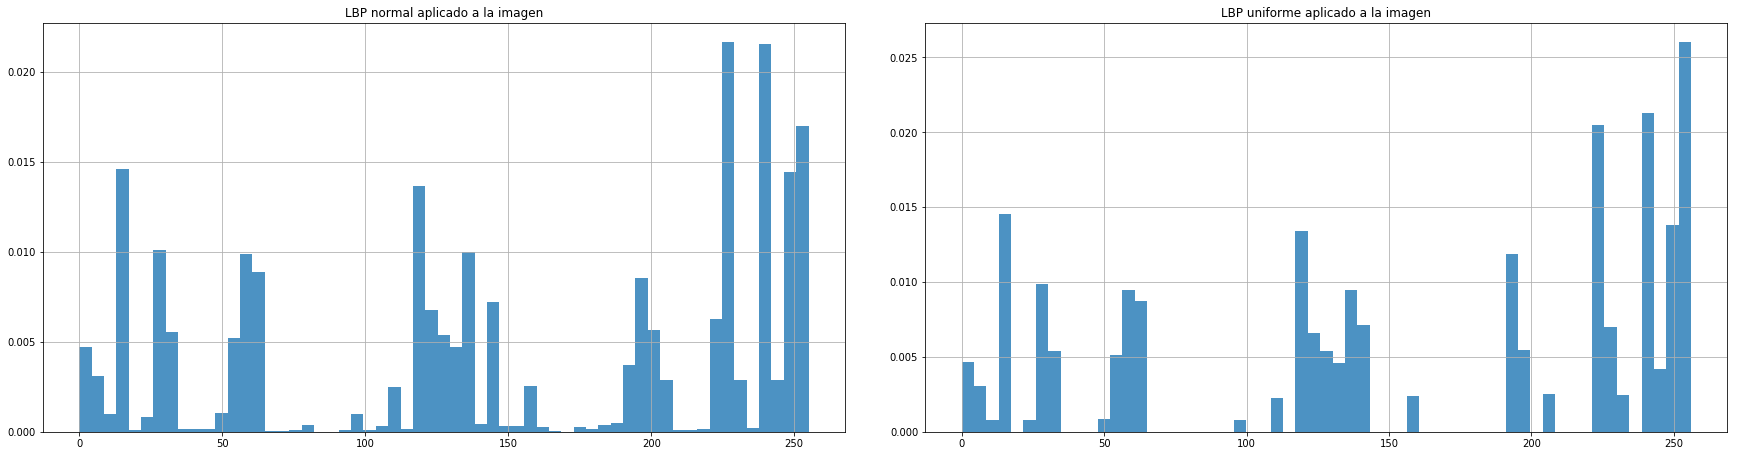

In [15]:
plt.figure(2)

hist_img2=list(lbp_img2.getdata())
plt.subplot(121)
plt.hist(hist_img2,59,alpha=0.8, normed=True)
plt.title("LBP normal aplicado a la imagen")
#plt.xlim((0,255))
plt.grid(True)


hist_unif_img2=list(lbp_unif_img2.getdata())

plt.subplot(122)
plt.hist(hist_unif_img2,59,alpha=0.8, normed=True)
plt.title("LBP uniforme aplicado a la imagen")
#plt.xlim((0,58))
plt.grid(True)

plt.subplots_adjust(top=1.5, bottom=0.08, left=0.10, right=4, hspace=0.34,
                    wspace=0.1) 

### 3. Dividir imagen en 4 partes

In [6]:
def dividir4(img):
    a1=img.crop((0,0,100,100))
    a2=img.crop((100,0,200,100))
    a3=img.crop((0,100,100,200))
    a4=img.crop((100,100,200,200))
    return a1, a2, a3, a4

# Preparar la data con los histogramas LBP

#### Se guardan los histogramas LBP de cada imagen en un data frame df_hist_lbp, luego son guardados como "df_hist_lbp.csv"

In [17]:
ruta="/home/jose/Desktop/Web Intelligence t1/Data/"

df_hist_lbp=[]

#keys corresponde a los valores que pueden tomar los pixeles con lbp_uniforme 58+1 
keys=[0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 12.0, 14.0, 15.0, 16.0, 24.0, 28.0, 30.0, 31.0, 32.0, 48.0, 56.0, 60.0, 62.0,
   63.0, 64.0, 96.0, 112.0, 120.0, 124.0, 126.0, 127.0, 128.0, 129.0, 131.0, 135.0, 143.0, 159.0, 191.0, 192.0, 193.0,
   195.0, 199.0, 207.0, 223.0, 224.0, 225.0, 227.0, 231.0, 239.0, 240.0, 241.0, 243.0, 247.0, 248.0, 249.0, 251.0,
   252.0, 253.0, 254.0, 255.0, 256.0]

for i in df.index:
    image_orig=Image.open(ruta+df['foto'][i]+".jpg")
    image_crop=CropFace(image_orig,(df['xl'][i],df['yl'][i]),(df['xr'][i],df['yr'][i]),offset_pct=(0.3,0.35),dest_sz=(200,200))
    im1,im2,im3,im4=dividir4(image_crop)
    #calc blp (entrega un data frame con la llave y el valor)
    lbp1=hist_lbp(im1)
    lbp2=hist_lbp(im2)
    lbp3=hist_lbp(im3)
    lbp4=hist_lbp(im4)
    lbps=[lbp1,lbp2,lbp3,lbp4]
    v=[]
    for i in range(0,4):
        lb=lbps[i]
        for k_i in keys:
            try:
                v.append(lb['val'][k_i])
            except KeyError:
                v.append(0)
    df_hist_lbp.append(v)

#crear el nombre de las columnas como keys*4
col=[]
for i in range(1,5):
    for k in keys:
        ci=str(k)+"_"+str(i)
        col.append(ci)

df_hist_lbp=pd.DataFrame(df_hist_lbp,columns=col)
df_hist_lbp['gender']=df['gender']
df_hist_lbp.to_csv("/home/jose/Desktop/Web Intelligence t1/data_frames/df_hist_lbp.csv",index=False)

#### Se guardan las imágenes en su forma LBP en un data frame df_ima_lbp, luego son guardados como "df_ima_lbp.csv"

In [19]:
ruta="/home/jose/Desktop/Web Intelligence t1/Data/"

df_ima_lbp=[]
for i in df.index:
    image_orig=Image.open(ruta+df['foto'][i]+".jpg")
    image_crop=CropFace(image_orig,(df['xl'][i],df['yl'][i]),(df['xr'][i],df['yr'][i]),offset_pct=(0.3,0.35),dest_sz=(200,200))
    im1,im2,im3,im4=dividir4(image_crop)
    #calc blp
    lbp1=lbp_unif(im1).ravel()
    lbp2=lbp_unif(im2).ravel()
    lbp3=lbp_unif(im3).ravel()
    lbp4=lbp_unif(im4).ravel()
    lbps=np.array([lbp1,lbp2,lbp3,lbp4])
    df_ima_lbp.append(lbps.ravel())

df_ima_lbp=pd.DataFrame(df_ima_lbp)
df_ima_lbp['gender']=df['gender']

df_ima_lbp.to_csv("/home/jose/Desktop/Web Intelligence t1/data_frames/df_ima_lbp.csv",index=False)

## Realizar entrenamiento del SVM para la primera base de datos

#### Inicio la función que va a correr los diferentes clasificadores (Esta función fue extraída del laboratorio 2 de Inroducción a la minería de datos del DCC)

In [6]:
def run_classifier(clf, X, y, num_tests=100):
    metrics = {'f1-score': [], 'precision': [], 'recall': [], 'accuracy': []}
    confusion = 0
    for _ in range(num_tests):
        
        ### INICIO COMPLETAR ACÁ 
        #### TIP: divida el dataset, entrene y genere las predicciones.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, stratify=y)
    
        clf.fit(X_train,y_train)
        
        predictions=clf.predict(X_test)        
        ### FIN COMPLETAR ACÁ
        
        metrics['f1-score'].append(f1_score(y_test, predictions))  # X_test y y_test deben ser definidos previamente
        metrics['recall'].append(recall_score(y_test, predictions))
        metrics['precision'].append(precision_score(y_test, predictions))
        metrics['accuracy'].append(accuracy_score(y_test,predictions))
        confusion= confusion + np.array(confusion_matrix(y_test, predictions))
    return metrics, confusion/num_tests

### 1. SVM

In [20]:
#keys corresponde a los valores que pueden tomar los pixeles con lbp_uniforme 58+1 
keys=[0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 12.0, 14.0, 15.0, 16.0, 24.0, 28.0, 30.0, 31.0, 32.0, 48.0, 56.0, 60.0, 62.0,
   63.0, 64.0, 96.0, 112.0, 120.0, 124.0, 126.0, 127.0, 128.0, 129.0, 131.0, 135.0, 143.0, 159.0, 191.0, 192.0, 193.0,
   195.0, 199.0, 207.0, 223.0, 224.0, 225.0, 227.0, 231.0, 239.0, 240.0, 241.0, 243.0, 247.0, 248.0, 249.0, 251.0,
   252.0, 253.0, 254.0, 255.0, 256.0]
##Columnas
col=[]
for i in range(1,5):
    for k in keys:
        ci=str(k)+"_"+str(i)
        col.append(ci)

In [53]:
ruta_df="/home/jose/Desktop/Web Intelligence t1/data_frames/"

df_hist_lbp=pd.read_csv(ruta_df+"df_hist_lbp.csv")
        
X = df_hist_lbp[col]
y = df_hist_lbp['gender']

y1=[]
for i in range(0,len(y)):
    if(y[i]=="male"):
        y1.append(1)
    else:
        y1.append(0)

c0 = ("SVC_rbf:",svm.SVC(gamma='scale', kernel="rbf")) #otros clasificadores son  SVC, NuSVC and LinearSVC
c1 = ("SVC_poly:",svm.SVC(gamma='auto', kernel="poly")) #otros clasificadores son  SVC, NuSVC and LinearSVC
c2 = ("SVC_sigmoid:",svm.SVC(gamma='scale', kernel="sigmoid")) #otros clasificadores son  SVC, NuSVC and LinearSVC
c3 = ("NuSVC:",svm.NuSVC(gamma="scale"))
c4 = ("LinearSVC:",svm.LinearSVC()) #otros clasificadores son  SVC, NuSVC and LinearSVC


classifiers = [c0, c1, c2, c3, c4]

for name, clf in classifiers:
    metrics, confusion = run_classifier(clf, X, y1, num_tests=30)   # hay que implementarla en el bloque anterior.
    print("----------------")
    print("Resultados para clasificador: ",name) 
    print("accuracy: ", np.array(metrics['accuracy']).mean())
    print("Precision promedio:",np.array(metrics['precision']).mean())
    print("Recall promedio:",np.array(metrics['recall']).mean())
    print("F1-score promedio:",np.array(metrics['f1-score']).mean())
    print("matrix confusion promedio:\n", (confusion))
    print("----------------\n\n")
    

----------------
Resultados para clasificador:  SVC_rbf:
accuracy:  0.648611111111111
Precision promedio: 0.6022224471101332
Recall promedio: 0.8938888888888888
F1-score promedio: 0.718259009292037
matrix confusion promedio:
 [[24.2        35.8       ]
 [ 6.36666667 53.63333333]]
----------------


----------------
Resultados para clasificador:  SVC_poly:
accuracy:  0.6025000000000001
Precision promedio: 0.5717099969797216
Recall promedio: 0.9194444444444444
F1-score promedio: 0.6952542061962609
matrix confusion promedio:
 [[17.13333333 42.86666667]
 [ 4.83333333 55.16666667]]
----------------


----------------
Resultados para clasificador:  SVC_sigmoid:
accuracy:  0.6480555555555555
Precision promedio: 0.6019357502145014
Recall promedio: 0.8988888888888888
F1-score promedio: 0.7194811682097175
matrix confusion promedio:
 [[23.83333333 36.16666667]
 [ 6.06666667 53.93333333]]
----------------


----------------
Resultados para clasificador:  NuSVC:
accuracy:  0.8308333333333332
Precis

In [69]:
ruta_df="/home/jose/Desktop/Web Intelligence t1/data_frames/"

df_ima_lbp=pd.read_csv(ruta_df+"df_ima_lbp.csv")

X = df_ima_lbp[df_ima_lbp.columns[:-1]]
y = df_ima_lbp['gender']

y1=[]
for i in range(0,len(y)):
    if(y[i]=="male"):
        y1.append(1)
    else:
        y1.append(0)

c0 = ("SVC_rbf:",svm.SVC(gamma='scale', kernel="rbf")) #otros clasificadores son  SVC, NuSVC and LinearSVC
c1 = ("SVC_poly:",svm.SVC(gamma='scale', kernel="poly")) #otros clasificadores son  SVC, NuSVC and LinearSVC
c2 = ("SVC_sigmoid:",svm.SVC(gamma='scale', kernel="sigmoid")) #otros clasificadores son  SVC, NuSVC and LinearSVC
c3 = ("NuSVC:",svm.NuSVC(gamma="scale"))
c4 = ("LinearSVC:",svm.LinearSVC()) #otros clasificadores son  SVC, NuSVC and LinearSVC

classifiers = [c0, c1, c2, c3, c4]

for name, clf in classifiers:
    metrics, confusion = run_classifier(clf, X, y1, num_tests=3)   # hay que implementarla en el bloque anterior.
    print("----------------")
    print("Resultados para clasificador: ",name) 
    print("accuracy: ", np.array(metrics['accuracy']).mean())
    print("Precision promedio:",np.array(metrics['precision']).mean())
    print("Recall promedio:",np.array(metrics['recall']).mean())
    print("F1-score promedio:",np.array(metrics['f1-score']).mean())
    print("matrix confusion promedio:\n", (confusion))
    print("----------------\n\n")

----------------
Resultados para clasificador:  SVC_rbf:
accuracy:  0.6222222222222222
Precision promedio: 0.7678952991452991
Recall promedio: 0.35000000000000003
F1-score promedio: 0.47923989278893225
matrix confusion promedio:
 [[53.66666667  6.33333333]
 [39.         21.        ]]
----------------


----------------
Resultados para clasificador:  SVC_poly:
accuracy:  0.8777777777777778
Precision promedio: 0.8437116778149387
Recall promedio: 0.9277777777777777
F1-score promedio: 0.8835198799699925
matrix confusion promedio:
 [[49.66666667 10.33333333]
 [ 4.33333333 55.66666667]]
----------------


----------------
Resultados para clasificador:  SVC_sigmoid:
accuracy:  0.5
Precision promedio: 0.5
Recall promedio: 1.0
F1-score promedio: 0.6666666666666666
matrix confusion promedio:
 [[ 0. 60.]
 [ 0. 60.]]
----------------


----------------
Resultados para clasificador:  NuSVC:
accuracy:  0.6555555555555556
Precision promedio: 0.7911568857860418
Recall promedio: 0.4166666666666667
F1-s

# Segunda base de datos pfl83lfw

In [7]:
ruta="/home/jose/Desktop/Web Intelligence t1/pf83lfw/pf83_fixed/"
images=[]

for image in listdir(ruta):
    images.append(image)

#img=Image.open(ruta + images[2])
#img=CropFace(img,(100,99),(163 , 99),offset_pct=(0.25,0.3),dest_sz=(200,200))

df_lfw=[]
keys=[0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 12.0, 14.0, 15.0, 16.0, 24.0, 28.0, 30.0, 31.0, 32.0, 48.0, 56.0, 60.0, 62.0,
   63.0, 64.0, 96.0, 112.0, 120.0, 124.0, 126.0, 127.0, 128.0, 129.0, 131.0, 135.0, 143.0, 159.0, 191.0, 192.0, 193.0,
   195.0, 199.0, 207.0, 223.0, 224.0, 225.0, 227.0, 231.0, 239.0, 240.0, 241.0, 243.0, 247.0, 248.0, 249.0, 251.0,
   252.0, 253.0, 254.0, 255.0, 256.0]

for im in images:
    image_orig=Image.open(ruta+im)
    image_bn=image_orig.convert("L")
    image_crop=CropFace(image_bn,(100,99),(163,99),offset_pct=(0.25,0.3),dest_sz=(200,200)) #posicion de ojos
    im1,im2,im3,im4=dividir4(image_crop)
    #calc blp
    lbp1=hist_lbp(im1)
    lbp2=hist_lbp(im2)
    lbp3=hist_lbp(im3)
    lbp4=hist_lbp(im4)
    lbps=[lbp1,lbp2,lbp3,lbp4]
    v=[]
    for i in range(0,4):
        lb=lbps[i]
        for k_i in keys:
            try:
                v.append(lb['val'][k_i])
            except KeyError:
                v.append(0)
    df_lfw.append(v)
#columnas
col=[]
for i in range(1,5):
    for k in keys:
        ci=str(k)+"_"+str(i)
        col.append(ci)

df_lfw=pd.DataFrame(df_lfw,columns=col)
df_lfw['gender']=df['gender']

df_lfw.to_csv("/home/jose/Desktop/Web Intelligence t1/data_frames/df_lfw.csv",index=False)

### SVM para la segunda base de datos

##### Primero entrenamos el clasificador que mejor resultados obtuvo con toda la data entregada y predecimos la 2da base de datos

In [13]:
## Cargar data frames
ruta_df="/home/jose/Desktop/Web Intelligence t1/data_frames/"

df_lfw=pd.read_csv(ruta_df+"df_lfw.csv")
df_hist_lbp=pd.read_csv(ruta_df+"df_hist_lbp.csv")


## variables para entrenar
X = df_hist_lbp[col]
y = df_hist_lbp['gender']
y1=[]
for i in range(0,len(y)):
    if(y[i]=="male"):
        y1.append(1)
    else:
        y1.append(0)

clf = svm.NuSVC(gamma="scale")
clf.fit(X,y1)

genero1=clf.predict(df_lfw[col])

/home/jose/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (236) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


##### Ahora entrenamos un clasificador con el sistema visto anteriormente train y set varias veces

In [14]:
## Cargar data frames
ruta_df="/home/jose/Desktop/Web Intelligence t1/data_frames/"

df_lfw=pd.read_csv(ruta_df+"df_lfw.csv")
df_hist_lbp=pd.read_csv(ruta_df+"df_hist_lbp.csv")

## Funcion clasificadora que devuelve el clasificador
def run_classifier2(clf, X, y, num_tests=100):
    metrics = {'f1-score': [], 'precision': [], 'recall': [], 'accuracy': []}
    confusion = 0
    for _ in range(num_tests):
        
        ### INICIO COMPLETAR ACÁ 
        #### TIP: divida el dataset, entrene y genere las predicciones.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, stratify=y)
    
        clf.fit(X_train,y_train)
        
        predictions=clf.predict(X_test)        
        ### FIN COMPLETAR ACÁ
        
        metrics['f1-score'].append(f1_score(y_test, predictions))  # X_test y y_test deben ser definidos previamente
        metrics['recall'].append(recall_score(y_test, predictions))
        metrics['precision'].append(precision_score(y_test, predictions))
        metrics['accuracy'].append(accuracy_score(y_test,predictions))
        confusion= confusion + np.array(confusion_matrix(y_test, predictions))
    return metrics, confusion/num_tests, clf

## variables para entrenar
X = df_hist_lbp[col]
y = df_hist_lbp['gender']
y1=[]
for i in range(0,len(y)):
    if(y[i]=="male"):
        y1.append(1)
    else:
        y1.append(0)

## Entrenar mi clasificador        
clf = svm.NuSVC(gamma="scale")
metrics, confusion ,clf_train = run_classifier2(clf, X, y1, num_tests=5)

genero2=clf_train.predict(df_lfw[col])

/home/jose/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (236) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


##### Comparamos ambos resultados 

In [15]:
print("Claficador entrenado con toda la data")
print(pd.Series(genero1).value_counts())
print("------------------------------------------------------------")
print("Claficador entrenado como en la primera parte de la tarea")
print(pd.Series(genero2).value_counts())

generos=pd.DataFrame({'genero_clf1':genero1, 'genero_clf2':genero2})
generos.to_csv("/home/jose/Desktop/Web Intelligence t1/data_frames/predicciones_lfw.csv",index=False)

Claficador entrenado con toda la data
0    19274
1     5794
dtype: int64
------------------------------------------------------------
Claficador entrenado como en la primera parte de la tarea
0    21078
1     3990
dtype: int64


# Tercera base de datos Selfies de instagram

##### Con ese código se descargo selfies de instagram

In [70]:
#$ python setup.py install
#$ instagram-scraper -u <user> -p <pass> selfie --latest

In [13]:
images=[]
ruta="/home/jose/Desktop/Web Intelligence t1/selfie/"
for cosa in listdir(ruta):
    images.append(cosa)

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

##### Crear un data frame con la posición de los ojos utilizando Haar Cascade

In [161]:
xl=[]
yl=[]
xr=[]
yr=[]
name=[]
foto_ni=[]
for im in images:
    img = cv2.imread(ruta+im)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    try:
        for (x,y,w,h) in faces:
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes=eye_cascade.detectMultiScale(roi_gray)
            for (ex,ey,ew,eh) in eyes:
                cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        if(len(eyes)==2):
            xl.append(faces[0][0]+eyes[0][0]+eyes[0][2]/2)
            yl.append(faces[0][1]+eyes[0][1]+eyes[0][3]/2)
            xr.append(faces[0][0]+eyes[1][0]+eyes[1][2]/2)
            yr.append(faces[0][1]+eyes[1][1]+eyes[1][3]/2)
            name.append(im)
        elif(len(eyes)>=3):
            xl.append(faces[0][0]+eyes[-2][0]+eyes[-2][2]/2)
            yl.append(faces[0][1]+eyes[-2][1]+eyes[-2][3]/2)
            xr.append(faces[0][0]+eyes[-1][0]+eyes[-1][2]/2)
            yr.append(faces[0][1]+eyes[-1][1]+eyes[-1][3]/2)
            name.append(im)            
        else:
            foto_ni.append(im)
    except KeyError:
        foto_ni.append(im)

df_insta_eyes=pd.DataFrame({"name":name, "xl":xl,"yl":yl,"xr":xr,"yr":yr})
df_insta_eyes.to_csv("/home/jose/Desktop/Web Intelligence t1/data_frames/df_insta_eyes.csv", index=False)

##### Crear data frame con los histogramas lbp 

In [170]:
ruta_fto="/home/jose/Desktop/Web Intelligence t1/selfie/"
ruta_df="/home/jose/Desktop/Web Intelligence t1/data_frames/"

pd.read_csv(ruta_df+"df_insta_eyes.csv")
df_insta=[]

#keys corresponde a los valores que pueden tomar los pixeles con lbp_uniforme 58+1 
keys=[0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 12.0, 14.0, 15.0, 16.0, 24.0, 28.0, 30.0, 31.0, 32.0, 48.0, 56.0, 60.0, 62.0,
   63.0, 64.0, 96.0, 112.0, 120.0, 124.0, 126.0, 127.0, 128.0, 129.0, 131.0, 135.0, 143.0, 159.0, 191.0, 192.0, 193.0,
   195.0, 199.0, 207.0, 223.0, 224.0, 225.0, 227.0, 231.0, 239.0, 240.0, 241.0, 243.0, 247.0, 248.0, 249.0, 251.0,
   252.0, 253.0, 254.0, 255.0, 256.0]

for i in df_insta_eyes.index:
    image_orig=Image.open(ruta_fto+df_insta_eyes['name'][i])
    image_bn=image_orig.convert("L")
    image_crop=CropFace(image_bn,(df_insta_eyes['xl'][i],df_insta_eyes['yl'][i]),(df_insta_eyes['xr'][i],df_insta_eyes['yr'][i]),offset_pct=(0.27,0.3),dest_sz=(200,200))
    im1,im2,im3,im4=dividir4(image_crop)
    #calc blp (entrega un data frame con la llave y el valor)
    lbp1=hist_lbp(im1)
    lbp2=hist_lbp(im2)
    lbp3=hist_lbp(im3)
    lbp4=hist_lbp(im4)
    lbps=[lbp1,lbp2,lbp3,lbp4]
    v=[]
    for i in range(0,4):
        lb=lbps[i]
        for k_i in keys:
            try:
                v.append(lb['val'][k_i])
            except KeyError:
                v.append(0)
    df_insta.append(v)

#crear el nombre de las columnas como keys*4
col=[]
for i in range(1,5):
    for k in keys:
        ci=str(k)+"_"+str(i)
        col.append(ci)

df_insta=pd.DataFrame(df_insta,columns=col)
df_insta['gender']=df['gender']
df_insta.to_csv("/home/jose/Desktop/Web Intelligence t1/data_frames/df_insta.csv",index=False)

### SVM para la tercera base de datos

##### Primero entrenamos el clasificador que mejor resultados obtuvo con toda la data entregada y predecimos la 3ra base de datos

In [173]:
## Cargar data frames
ruta_df="/home/jose/Desktop/Web Intelligence t1/data_frames/"

df_insta=pd.read_csv(ruta_df+"df_insta.csv")
df_hist_lbp=pd.read_csv(ruta_df+"df_hist_lbp.csv")


## variables para entrenar
X = df_hist_lbp[col]
y = df_hist_lbp['gender']
y1=[]
for i in range(0,len(y)):
    if(y[i]=="male"):
        y1.append(1)
    else:
        y1.append(0)

clf = svm.NuSVC(gamma="scale")
clf.fit(X,y1)

genero1=clf.predict(df_insta[col])

##### Ahora entrenamos un clasificador con el sistema visto anteriormente train y set varias veces

In [174]:
## Cargar data frames
ruta_df="/home/jose/Desktop/Web Intelligence t1/data_frames/"

df_insta=pd.read_csv(ruta_df+"df_insta.csv")
df_hist_lbp=pd.read_csv(ruta_df+"df_hist_lbp.csv")

## Funcion clasificadora que devuelve el clasificador
def run_classifier2(clf, X, y, num_tests=100):
    metrics = {'f1-score': [], 'precision': [], 'recall': [], 'accuracy': []}
    confusion = 0
    for _ in range(num_tests):
        
        ### INICIO COMPLETAR ACÁ 
        #### TIP: divida el dataset, entrene y genere las predicciones.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, stratify=y)
    
        clf.fit(X_train,y_train)
        
        predictions=clf.predict(X_test)        
        ### FIN COMPLETAR ACÁ
        
        metrics['f1-score'].append(f1_score(y_test, predictions))  # X_test y y_test deben ser definidos previamente
        metrics['recall'].append(recall_score(y_test, predictions))
        metrics['precision'].append(precision_score(y_test, predictions))
        metrics['accuracy'].append(accuracy_score(y_test,predictions))
        confusion= confusion + np.array(confusion_matrix(y_test, predictions))
    return metrics, confusion/num_tests, clf

## variables para entrenar
X = df_hist_lbp[col]
y = df_hist_lbp['gender']
y1=[]
for i in range(0,len(y)):
    if(y[i]=="male"):
        y1.append(1)
    else:
        y1.append(0)

## Entrenar mi clasificador        
clf = svm.NuSVC(gamma="scale")
metrics, confusion ,clf_train = run_classifier2(clf, X, y1, num_tests=5)

genero2=clf_train.predict(df_insta[col])

##### Comparamos ambos resultados 

In [175]:
print("Claficador entrenado con toda la data")
print(pd.Series(genero1).value_counts())
print("------------------------------------------------------------")
print("Claficador entrenado como en la primera parte de la tarea")
print(pd.Series(genero2).value_counts())

generos=pd.DataFrame({'genero_clf1':genero1, 'genero_clf2':genero2})
generos.to_csv("/home/jose/Desktop/Web Intelligence t1/data_frames/predicciones_insta.csv",index=False)

Claficador entrenado con toda la data
1    96
0    39
dtype: int64
------------------------------------------------------------
Claficador entrenado como en la primera parte de la tarea
1    97
0    38
dtype: int64
